<a href="https://colab.research.google.com/github/farenga/neuralODE/blob/main/2_Lotka_Volterra_Spiral_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spiral Lotka-Volterra Ensemble

Equations:

$$
\begin{cases}    
\dot{u_1}(t) = u_1(t)(\mu-0.1u_1(t)-0.5u_2(t)-0.5u_3(t))\\
\dot{u_2}(t) = u_2(t)(-\mu+0.5u_1(t)-0.3u_3(t))\\
\dot{u_3}(t) = u_3(t)(-\mu+0.2u_1(t)+0.5u_2(t))\\
u_i(0) = 0.5 \quad\end{cases} \qquad\mu = 1.95
$$

so since $\mathbf{f}(u(t),t,\theta)$

We tackle the problem by training 10 Neural ODEs models with different initializations, to build an ensamble model, allowing us to retrieve uncertainty-related infos.

In [100]:
!pip install torchdiffeq

In [101]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

In [102]:
method = 'dopr15'
data_size = 1000
batch_time = 200
batch_size = 50
niters = 2000
test_freq = 50
gpu = 0
viz = False
adjoint = False
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [103]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [104]:
true_u0 = torch.tensor([[.5, .5, .5]]).to(device)
t = torch.linspace(0., 10., data_size).to(device)

In [105]:
mu = 1.95

In [106]:
class Lambda(nn.Module):

    def forward(self, t, u):
      u1 = u[0][0]
      u2 = u[0][1]
      u3 = u[0][2]
      return torch.tensor([ 
                            [ u1*(mu - .1*u1 - .5*u2 - .5*u3) ],
                            [ u2*(-mu + .5*u1 - .3*u3) ],
                            [ u3*(-mu + .2*u1 + .5*u2) ]
                             
                             ]).reshape([1,3]).to(device)


In [107]:
with torch.no_grad():
    true_u = odeint(Lambda(), true_u0, t, method='dopri5') # [time,state] = [t,u(t)]

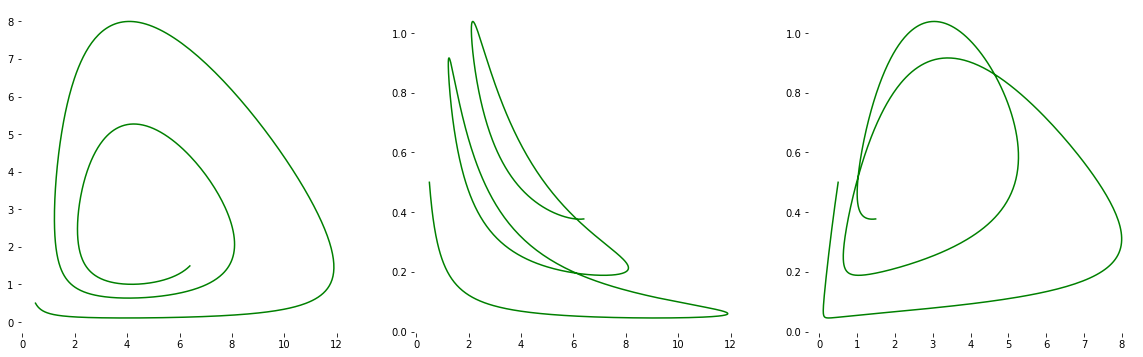

In [108]:
fig = plt.figure(figsize=(20, 6), facecolor='white')
ax_phase_1_true = fig.add_subplot(131, frameon=False)
ax_phase_1_true.plot(true_u[:, :, 0], true_u[:, :, 1], 'g-')
ax_phase_2_true = fig.add_subplot(132, frameon=False)
ax_phase_2_true.plot(true_u[:, :, 0], true_u[:, :, 2], 'g-')
ax_phase_3_true = fig.add_subplot(133, frameon=False)
ax_phase_3_true.plot(true_u[:, :, 1], true_u[:, :, 2], 'g-')

In [109]:
def get_batch():
    # generate a tensor of N=batch_size random indices in the range(0,data_size-batch_time) -> 100-10 = 90
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_u[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_u[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)


In [110]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [111]:
if viz:
    makedirs('png')
    fig = plt.figure(figsize=(20, 6), facecolor='white')
#   ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase_1 = fig.add_subplot(131, frameon=False)
    ax_phase_2 = fig.add_subplot(132, frameon=False)
    ax_phase_3 = fig.add_subplot(133, frameon=False)
#   ax_vecfield = fig.add_subplot(133, frameon=False)
    plt.show(block=False)

In [112]:
plot_x_lim = 3
plot_y_lim = 3

def visualize(true_u, pred_u, odefunc, itr, batch_y, batch_t):

    if viz:

        ax_phase_1.cla()
        ax_phase_1.set_title('Phase Portrait, Species 1-2')
        ax_phase_1.set_xlabel('x1')
        ax_phase_1.set_ylabel('x2')
        ax_phase_1.plot(true_u.cpu().numpy()[:, 0, 0], true_u.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase_1.plot(pred_u.cpu().numpy()[:, 0, 0], pred_u.cpu().numpy()[:, 0, 1], 'b--')
        ax_phase_1.plot(batch_u0.cpu().numpy()[:, 0, 0], batch_u0.cpu().numpy()[:, 0, 1], 'r*')
        #ax_phase_1.set_xlim(0, plot_x_lim)
        #ax_phase_1.set_ylim(0, plot_y_lim)
        
        ax_phase_2.cla()
        ax_phase_2.set_title('Phase Portrait, Species 1-3')
        ax_phase_2.set_xlabel('x1')
        ax_phase_2.set_ylabel('x3')
        ax_phase_2.plot(true_u.cpu().numpy()[:, 0, 0], true_u.cpu().numpy()[:, 0, 2], 'g-')
        ax_phase_2.plot(pred_u.cpu().numpy()[:, 0, 0], pred_u.cpu().numpy()[:, 0, 2], 'b--')
        ax_phase_2.plot(batch_u0.cpu().numpy()[:, 0, 0], batch_u0.cpu().numpy()[:, 0, 2], 'r*')
        #ax_phase_2.set_xlim(0, plot_x_lim)
        #ax_phase_2.set_ylim(0, plot_y_lim)

        ax_phase_3.cla()
        ax_phase_3.set_title('Phase Portrait, Species 2-3')
        ax_phase_3.set_xlabel('x2')
        ax_phase_3.set_ylabel('x3')
        ax_phase_3.plot(true_u.cpu().numpy()[:, 0, 1], true_u.cpu().numpy()[:, 0, 2], 'g-')
        ax_phase_3.plot(pred_u.cpu().numpy()[:, 0, 1], pred_u.cpu().numpy()[:, 0, 2], 'b--')
        ax_phase_3.plot(batch_u0.cpu().numpy()[:, 0, 1], batch_u0.cpu().numpy()[:, 0, 2], 'r*')
        #ax_phase_3.set_xlim(0, plot_x_lim)
        #ax_phase_3.set_ylim(0, plot_y_lim)

        
        fig.tight_layout()
        fig.savefig('png/{:03d}'.format(itr))
        fig.show()
        #plt.draw()
        #plt.pause(0.001)

In [113]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 50),
            nn.ReLU(),
            nn.Linear(50, 3)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [114]:
def lr_schedule(loss):
  if(loss < .7):
    return 1e-5
  if(loss < 1):
    return 1e-4
  else:
    return 1e-3

In [115]:
batch_u0, batch_t, batch_u = get_batch()
batch_t

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0501, 0.0601, 0.0701, 0.0801,
        0.0901, 0.1001, 0.1101, 0.1201, 0.1301, 0.1401, 0.1502, 0.1602, 0.1702,
        0.1802, 0.1902, 0.2002, 0.2102, 0.2202, 0.2302, 0.2402, 0.2503, 0.2603,
        0.2703, 0.2803, 0.2903, 0.3003, 0.3103, 0.3203, 0.3303, 0.3403, 0.3504,
        0.3604, 0.3704, 0.3804, 0.3904, 0.4004, 0.4104, 0.4204, 0.4304, 0.4404,
        0.4505, 0.4605, 0.4705, 0.4805, 0.4905, 0.5005, 0.5105, 0.5205, 0.5305,
        0.5405, 0.5506, 0.5606, 0.5706, 0.5806, 0.5906, 0.6006, 0.6106, 0.6206,
        0.6306, 0.6406, 0.6507, 0.6607, 0.6707, 0.6807, 0.6907, 0.7007, 0.7107,
        0.7207, 0.7307, 0.7407, 0.7508, 0.7608, 0.7708, 0.7808, 0.7908, 0.8008,
        0.8108, 0.8208, 0.8308, 0.8408, 0.8509, 0.8609, 0.8709, 0.8809, 0.8909,
        0.9009, 0.9109, 0.9209, 0.9309, 0.9409, 0.9510, 0.9610, 0.9710, 0.9810,
        0.9910, 1.0010, 1.0110, 1.0210, 1.0310, 1.0410, 1.0511, 1.0611, 1.0711,
        1.0811, 1.0911, 1.1011, 1.1111, 

## Training

In [116]:
n = 10
ensemble = []
for j in range(n):
  ensemble.append(ODEFunc().to(device))


In [117]:
ensemble[0]

ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=3, bias=True)
  )
)

In [118]:
ii = 0
L2reg = False

for i,func in enumerate(ensemble):

  print("Model #"+str(i))

  optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
  #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,  verbose=False)
  sigma_prior = 0.1
  gamma = torch.Tensor([1/(2*sigma_prior**2)])
  loss_array = []
  itr_time = []

#  start = time.time()
  for itr in range(1, niters + 1):
      
      start_itr = time.time()

      optimizer.zero_grad()
      
      batch_u0, batch_t, batch_u = get_batch()
      pred_u = odeint(func, batch_u0, batch_t).to(device)
      
      if L2reg:
        weights=[]
        for ii,w in enumerate(func.parameters()):
          if ii%2 == 0:
            w = torch.reshape(w,(1,300))
            weights.append(w)
        weigths = torch.stack(weights)
        weigths_prior = sigma_prior*torch.randn_like(weigths)
        loss = torch.mean(torch.pow(pred_u - batch_u,2))+torch.mean(torch.sqrt(gamma)*torch.pow(weigths - weigths_prior,2))
      else:
        loss = torch.mean(torch.pow(pred_u - batch_u,2))

      loss.backward()
      optimizer.step()
      #scheduler.step(loss)
      
      itr_time.append(time.time()-start_itr)
      
      if itr % test_freq == 0:
        with torch.no_grad():
       #       pred_u = odeint(func, true_u0, t)
       #       loss = torch.mean(torch.abs(pred_u - true_u))
               loss_array.append(loss.item())
               print('Iter ' + str(itr)+'/'+str(niters) + '  |  Loss: ' + str(round(loss.item(),6)) + '  |  lr: ' + str(optimizer.param_groups[0]['lr']) + ' |  itr time: ' +str(round(itr_time[-1],5))+' s')
       #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
       #       ii += 1

#total_elapsed_time = time.time()-start

Model #0
Iter 50/2000  |  Loss: 5.956192  |  lr: 0.001 |  itr time: 0.50856 s
Iter 100/2000  |  Loss: 3.27149  |  lr: 0.001 |  itr time: 0.26742 s
Iter 150/2000  |  Loss: 2.213699  |  lr: 0.001 |  itr time: 0.38184 s
Iter 200/2000  |  Loss: 1.25697  |  lr: 0.001 |  itr time: 0.42475 s
Iter 250/2000  |  Loss: 1.161814  |  lr: 0.001 |  itr time: 0.57492 s
Iter 300/2000  |  Loss: 1.034287  |  lr: 0.001 |  itr time: 0.59551 s
Iter 350/2000  |  Loss: 0.930657  |  lr: 0.001 |  itr time: 0.66913 s
Iter 400/2000  |  Loss: 0.751371  |  lr: 0.001 |  itr time: 0.72031 s
Iter 450/2000  |  Loss: 0.569534  |  lr: 0.001 |  itr time: 0.69596 s
Iter 500/2000  |  Loss: 0.439505  |  lr: 0.001 |  itr time: 0.78894 s
Iter 550/2000  |  Loss: 0.435106  |  lr: 0.001 |  itr time: 0.85447 s
Iter 600/2000  |  Loss: 0.309213  |  lr: 0.001 |  itr time: 0.76669 s
Iter 650/2000  |  Loss: 0.307046  |  lr: 0.001 |  itr time: 0.83628 s
Iter 700/2000  |  Loss: 0.274607  |  lr: 0.001 |  itr time: 0.90131 s
Iter 750/2000 

## Extrapolation

In [119]:
t_train = t[:batch_time]
t_test = t[batch_time:]
t = t

with torch.no_grad():
    true_u_train = odeint(Lambda(), true_u0, t_train, method='dopri5') # [time,state] = [t,u(t)]
    true_u_test = odeint(Lambda(), true_u_train[-1], t_test, method='dopri5') # [time,state] = [t,u(t)]
    true_u = odeint(Lambda(), true_u0, t, method='dopri5')

In [120]:
pred = []
for func in ensemble:
  pred.append(odeint(func, true_u0, t).to(device))

In [121]:
pred_tensor = torch.stack(pred)

In [122]:
with torch.no_grad():
  mean_pred = torch.mean(pred_tensor,0)

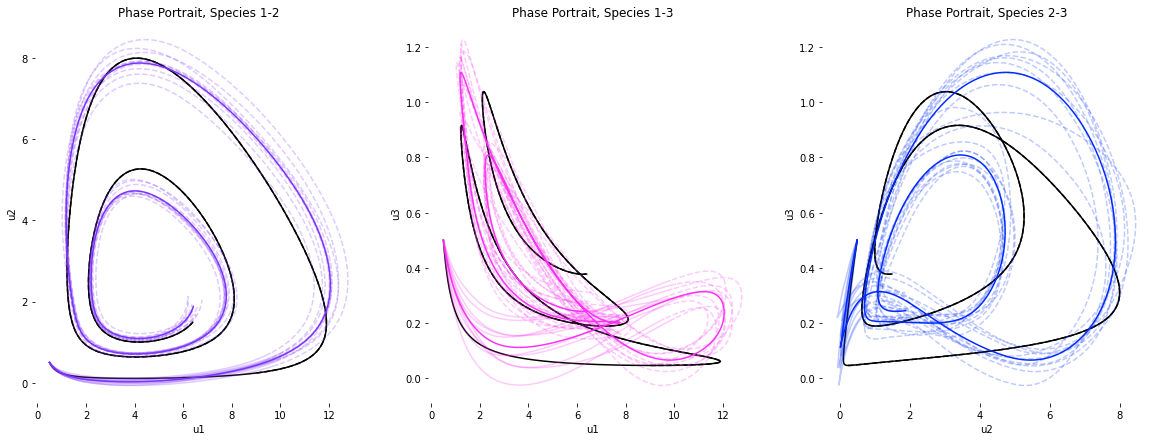

In [123]:
fig = plt.figure(figsize=(20, 7), facecolor='white')

colors = ['#7d34fa','#fa34f3','#032cfc','#ff006f','#00ffd5','#62ff57']
gtc = '#000000'
ax_phase_1_test = fig.add_subplot(131, frameon=False)
ax_phase_1_test.set_title('Phase Portrait, Species 1-2')
ax_phase_1_test.set_xlabel('u1')
ax_phase_1_test.set_ylabel('u2')
ax_phase_1_test.plot(true_u[:, :, 0], true_u[:, :, 1], '-', color=gtc)
ax_phase_1_test.plot(true_u_test[:, :, 0], true_u_test[:, :, 1], '--', color=gtc)
ax_phase_1_test.plot(mean_pred[:, :, 0], mean_pred[:, :, 1], '-', color=colors[0])


ax_phase_2_test = fig.add_subplot(132, frameon=False)
ax_phase_2_test.set_title('Phase Portrait, Species 1-3')
ax_phase_2_test.set_xlabel('u1')
ax_phase_2_test.set_ylabel('u3')
ax_phase_2_test.plot(true_u[:, :, 0], true_u[:, :, 2], '-', color=gtc)
ax_phase_2_test.plot(true_u_test[:, :, 0], true_u_test[:, :, 2], '--', color=gtc)
ax_phase_2_test.plot(mean_pred[:, :, 0], mean_pred[:, :, 2], '-', color=colors[1])


ax_phase_3_test = fig.add_subplot(133, frameon=False)
ax_phase_3_test.set_title('Phase Portrait, Species 2-3')
ax_phase_3_test.set_xlabel('u2')
ax_phase_3_test.set_ylabel('u3')
ax_phase_3_test.plot(true_u[:, :, 1], true_u[:, :, 2], '-', color=gtc)
ax_phase_3_test.plot(true_u_test[:, :, 1], true_u_test[:, :, 2], '--', color=gtc)
ax_phase_3_test.plot(mean_pred[:, :, 1], mean_pred[:, :, 2], '-', color=colors[2])

a=.25
for pred_u in pred:
  ax_phase_1_test.plot(pred_u.detach().numpy()[:len(t_train), :, 0], pred_u.detach().numpy()[:len(t_train), :, 1], '-', color=colors[0],alpha=a)
  ax_phase_1_test.plot(pred_u.detach().numpy()[len(t_train):, :, 0], pred_u.detach().numpy()[len(t_train):, :, 1], '--', color=colors[0],alpha=a)
  ax_phase_2_test.plot(pred_u.detach().numpy()[:len(t_train), :, 0], pred_u.detach().numpy()[:len(t_train), :, 2], '-', color=colors[1],alpha=a)
  ax_phase_2_test.plot(pred_u.detach().numpy()[len(t_train):, :, 0], pred_u.detach().numpy()[len(t_train):, :, 2], '--',  color=colors[1],alpha=a)
  ax_phase_3_test.plot(pred_u.detach().numpy()[:len(t_train), :, 1], pred_u.detach().numpy()[:len(t_train), :, 2], '-',  color=colors[2],alpha=a)
  ax_phase_3_test.plot(pred_u.detach().numpy()[len(t_train):, :, 1], pred_u.detach().numpy()[len(t_train):, :, 2], '--',  color=colors[2],alpha=a)


In [124]:
def ensemble_pred(ensemble, u0, t):
  pred = []
  for func in ensemble:
    pred.append(odeint(func, u0, t).to(device))
    pred_tensor = torch.stack(pred)
    mean_pred = torch.mean(pred_tensor,0)
    std_pred = torch.std(pred_tensor,0)
  return mean_pred,std_pred

In [125]:
mean_pred,std_pred = ensemble_pred(ensemble, true_u0, t)

In [126]:
len(t)

1000

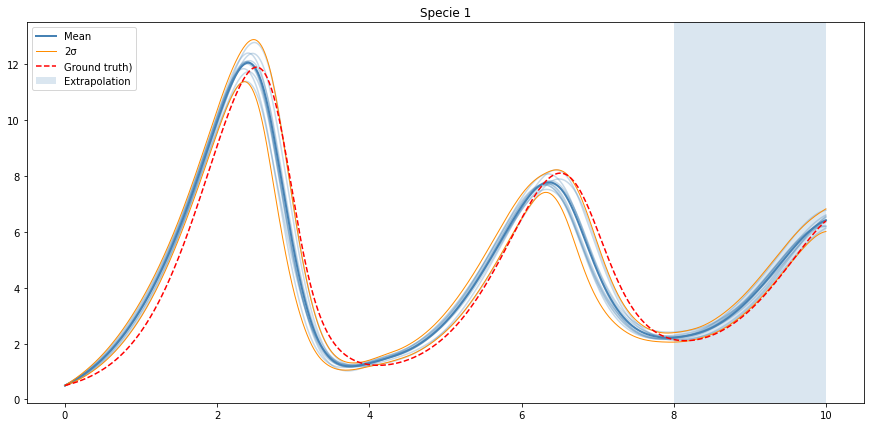

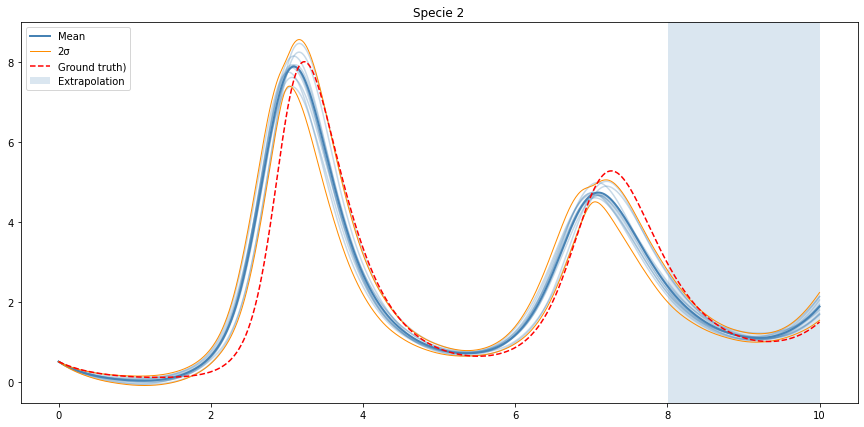

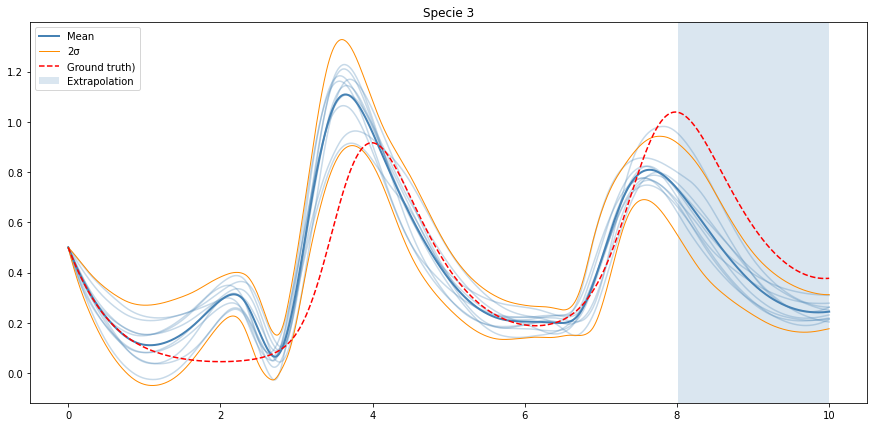

In [134]:
a = .3
for j in range(3):
  fig = plt.figure(figsize=(15, 7), facecolor='white',frameon=False)

  for pred_u in pred:
    plt.plot(t,pred_u[:, :, j].detach().numpy(),color='steelblue',alpha=a)

  plt.plot(t,mean_pred[:, :, j].detach().numpy(),color='steelblue',linewidth=2,label='Mean')
  plt.plot(t,mean_pred[:, :, j].detach().numpy()+2*std_pred[:, :, j].detach().numpy(),color='darkorange',label='2σ',linewidth=1)
  plt.plot(t,mean_pred[:, :, j].detach().numpy()-2*std_pred[:, :, j].detach().numpy(),color='darkorange',linewidth=1)

  plt.plot(t,true_u[:, :, j],'--r',label='Ground truth)')
  plt.axvspan(t[data_size-batch_time], t[-1], facecolor='steelblue', alpha=0.2,label='Extrapolation')
  plt.title('Specie '+str(j+1))
  plt.legend()

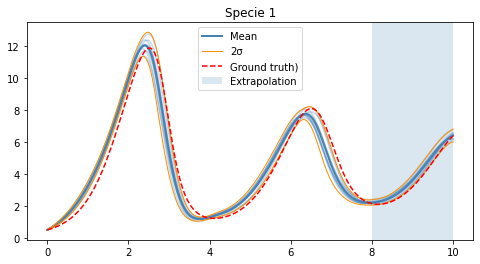

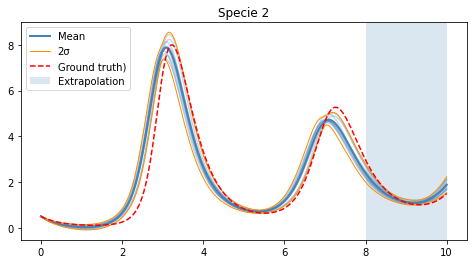

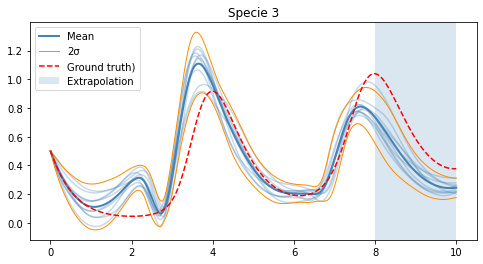

In [135]:
a = .3
for j in range(3):
  fig = plt.figure(figsize=(8, 4), facecolor='white',frameon=False)

  for pred_u in pred:
    plt.plot(t,pred_u[:, :, j].detach().numpy(),color='steelblue',alpha=a)

  plt.plot(t,mean_pred[:, :, j].detach().numpy(),color='steelblue',linewidth=2,label='Mean')
  plt.plot(t,mean_pred[:, :, j].detach().numpy()+2*std_pred[:, :, j].detach().numpy(),color='darkorange',label='2σ',linewidth=1)
  plt.plot(t,mean_pred[:, :, j].detach().numpy()-2*std_pred[:, :, j].detach().numpy(),color='darkorange',linewidth=1)

  plt.plot(t,true_u[:, :, j],'--r',label='Ground truth)')
  plt.axvspan(t[data_size-batch_time], t[-1], facecolor='steelblue', alpha=0.2,label='Extrapolation')
  plt.title('Specie '+str(j+1))
  plt.legend()

In [128]:
mu,sigma = ensemble_pred(ensemble, true_u0, t)

In [129]:
weights=[]
for w in ensemble[0].parameters():
  weights.append(w.detach().numpy())

Text(0.5, 1.0, 'Layer 2 Weights Distribution')

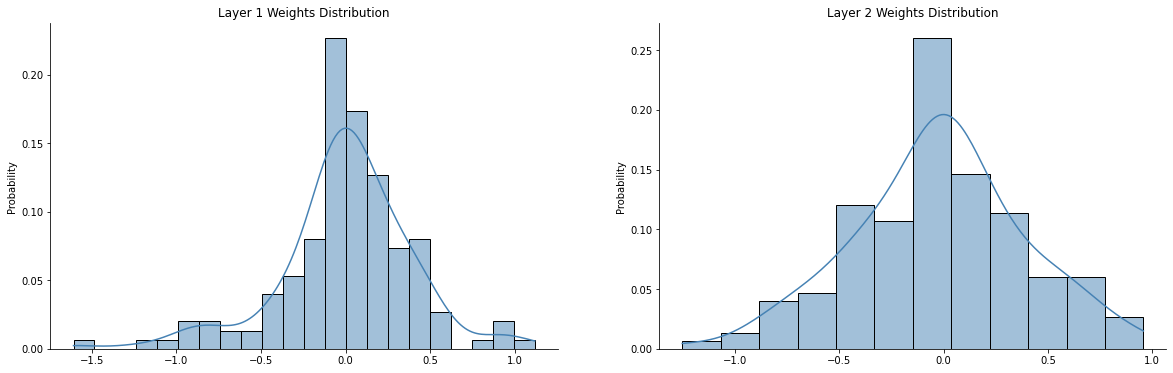

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.despine(fig)

sns.histplot(weights[0].reshape(150),kde=True,stat='probability',color="steelblue", label="Layer 1",ax=axes[0]).set_title('Layer 1 Weights Distribution')
sns.histplot(weights[2].reshape(150),kde=True,stat='probability',color="steelblue", label="Layer 1",ax=axes[1]).set_title('Layer 2 Weights Distribution')